In [15]:
from simulate import simulate_convergence
import torch
from utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
_, x = make_grid(n_side = 7)
x = (x * 0.5) + 0.25

In [67]:
x[24]

tensor([0.5000, 0.5000])

(-0.9, -0.1)

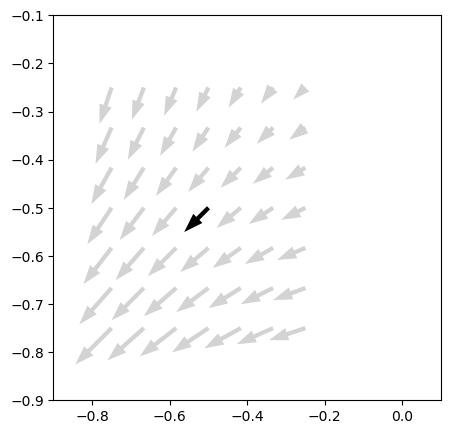

In [85]:
plt.figure(figsize = (5, 5))
plt.quiver(
    - x[:, 0], 
    - x[:, 1], 
    y[:, 0],
    y[:, 1], scale = 8, width = 0.011, headwidth = 3, headlength = 4.5, color = "lightgrey")
plt.quiver(
    - x[24, 0], 
    - x[24, 1], 
    y[24, 0],
    y[24, 1], scale = 8, width = 0.011, headwidth = 3, headlength = 4.5, color = "black")
plt.xlim(-0.9,0.1)
plt.ylim(-0.9,-0.1)